# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import random   
# from buffer import ReplayBuffer
from maddpg import MADDPG
import torch
import time, os
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline

In [2]:
env = UnityEnvironment(file_name="/home/sayantani.bhattacharya/Desktop/Navigation-Proj/Value-based-methods/p3_collab-compet/Tennis_Linux/Tennis.x86_64") # worker_id = 1

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

Utility funtions:

In [4]:
def seeding(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)

def pre_process(entity, batchsize):
    processed_entity = []
    for j in range(3):
        list = []
        for i in range(batchsize):
            b = entity[i][j]
            list.append(b)
        c = torch.Tensor(list)
        processed_entity.append(c)
    return processed_entity

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. MADDPG Agent Function

In [6]:
# Creating the agent
maddpg_agent = MADDPG(state_size=state_size, action_size = brain.vector_action_space_size, num_agents = 2, random_seed = 2012)
# to debug
print(state_size)

24


In [7]:
scores_max_hist = []
scores_mean_hist = []

def maddpg_train(n_episodes=3000):
    
    scores_deque = deque(maxlen=100)
    solved = False
    
    for i_episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        scores = np.zeros(num_agents)
        maddpg_agent.reset()
        step = 0
        # Can put a max iteration limit in the next loop.
        while True:  
            step += 1
            action = maddpg_agent.act(state, i_episode, add_noise=True)
            env_info = env.step(action)[brain_name]
            
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            
            scores += reward            
            maddpg_agent.step(i_episode, state, action, reward, next_state, done)

            if np.any(done):
                break
                
            state = next_state

        score_max = np.max(scores)
        scores_deque.append(score_max)
        score_mean = np.mean(scores_deque)
        
        scores_max_hist.append(score_max)
        scores_mean_hist.append(score_mean)

        print('\r{} episode\tavg score {:.5f}\tmax score {:.5f}'.format(i_episode, np.mean(scores_deque), score_max), end='')
        if solved == False and score_mean >= 0.5:
            print('\nEnvironment solved after {} episodes with the average score {}\n'.format(i_episode, score_mean))
            maddpg_agent.save()
            solved = True
            break
        
        if i_episode % 200 == 0:
            print()

### 4. Code execution and plotting

0 episode	avg score 0.00000	max score 0.00000
200 episode	avg score 0.01950	max score 0.00000
400 episode	avg score 0.01400	max score 0.00000
600 episode	avg score 0.00090	max score 0.00000
800 episode	avg score 0.00360	max score 0.00000
1000 episode	avg score 0.07200	max score 0.00000
1200 episode	avg score 0.09600	max score 0.10000
1400 episode	avg score 0.14480	max score 0.10000
1545 episode	avg score 0.50170	max score 2.70000
Environment solved after 1545 episodes with the average score 0.5017000075243413



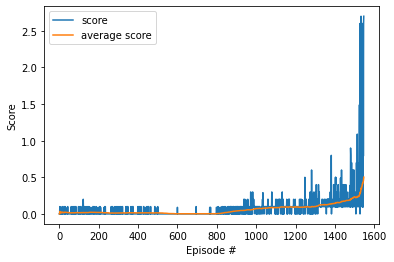

In [8]:
maddpg_train() 

fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.plot(np.arange(1, len(scores)+1), scores)
# plt.ylabel('Score')
# plt.xlabel('Episode #')
# plt.show()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_max_hist)+1), scores_max_hist, label='score')
plt.plot(np.arange(1, len(scores_mean_hist)+1), scores_mean_hist, label='average score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

